In [18]:
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [19]:
def class_from_filename(filename):
    if filename.count('_') == 2:
        label, _, _ = filename.split('_')
    elif filename.count('_') == 3:
        # pwd_mkdb
        label, tmp, _, _ = filename.split('_')
        label += '_' + tmp
    else:
        print(f'Unknown file name format: {filename}')
        raise ValueError()
    return label

In [20]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes/'
unusable_threshold = 10
rare_threshold = 50
splits = (0.7, 0.15, 0.15)

max_sequence_length = 100

assert(sum(splits) == 1)

print(f'experiment parameters: \n{data_directory=} \n{unusable_threshold=} \n{rare_threshold=} \n{splits=} \n{max_sequence_length=}')

experiment parameters: 
data_directory='/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes/' 
unusable_threshold=10 
rare_threshold=50 
splits=(0.7, 0.15, 0.15) 
max_sequence_length=100


In [21]:
total_classes = 0

# unusable classes will be removed from the dataset
unusable_classes = []
# rare classes will be oversampled
rare_classes = []

# all classes in training data (all classes - unusable classes)
classes = []

# walk all files, build unusable_classes, rare_classes
classes_occurrences = Counter()
for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    classes_occurrences[label] += 1

total_classes = len(classes_occurrences)
for label, count in classes_occurrences.items():
    if count < unusable_threshold:
        unusable_classes.append(label)
    elif count < rare_threshold:
        rare_classes.append(label)
        classes.append(label)
    else:
        classes.append(label)

print(f'Total classes: {total_classes}')
print(f'Unusable classes: {len(unusable_classes)}')
print(f'\t{unusable_classes}')
print(f'Rare classes: {len(rare_classes)}')
print(f'\t{rare_classes}')

labels_cardinality = len(set(classes))
print(f'Usable classes: {labels_cardinality}')

Total classes: 118
Unusable classes: 51
	['ping', 'pwd_mkdb', 'vi', 'tr', 'uname', 'msgs', 'screen', 'pw', 'bzip2', 'bzcat', 'nginx', 'stat', 'tail', 'smtp', 'kenv', 'nawk', 'ssh', 'chown', 'cut', 'php-fpm', 'jot', 'xz', 'diff', 'bounce', 'links', 'ipfw', 'touch', 'env', 'pfctl', 'minions', 'csh', 'kldstat', 'su', 'nohup', 'stty', 'df', 'limits', 'id', 'postmap', 'ifconfig', 'chkgrp', 'ipfstat', 'locale', 'devd', 'uniq', 'XIM', 'getty', 'which', 'init', 'test', 'nice']
Rare classes: 20
	['wc', 'grep', 'mktemp', 'less', 'tty', 'mailwrapper', 'kill', 'lockf', 'mount', 'tee', 'expr', 'ps', 'route', 'sed', 'cmp', 'egrep', 'sort', 'basename', 'awk', 'mail']
Usable classes: 67


In [22]:
# split into train, validation, test
labels_set = set()

filenames_all = []

filenames_train = []
filenames_val = []
filenames_test = []

for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    if label in unusable_classes:
        continue
    labels_set.add(label)
    filenames_all.append(filename)

# stratisfied split
test_vs_val = splits[2] / (splits[1] + splits[2])
filenames_train, filenames_val_test = train_test_split(filenames_all, test_size=splits[1]+splits[2], stratify=[class_from_filename(f) for f in filenames_all], random_state=42)
filenames_val, filenames_test = train_test_split(filenames_val_test, test_size=test_vs_val, stratify=[class_from_filename(f) for f in filenames_val_test], random_state=42)

print(f'Train: {len(filenames_train)}')
print(f'Validation: {len(filenames_val)}')
print(f'Test: {len(filenames_test)}')

# build labels_map in alphabetical order
labels_map = {}
for i, label in enumerate(sorted(labels_set)):
    labels_map[label] = i

Train: 150475
Validation: 32245
Test: 32245


In [23]:
# load data
# in preparation, load all data and build sets of unique features for later one-hot encoding, simultaneously vectorize labels and features
event_types_map = {}
users_map = {}
filetypes_map = {}

def parse_line(line):
    """
    Parse a line from the dataset and return the vectorized values. Not a pure function (builds distinct_* maps)!
    """
    event, user, filetype1, filetype2 = line.strip().split(',')
    # vectorize
    event = event_types_map.setdefault(event, len(event_types_map))
    user = users_map.setdefault(user, len(users_map))
    filetype1 = filetypes_map.setdefault(filetype1, len(filetypes_map))
    filetype2 = filetypes_map.setdefault(filetype2, len(filetypes_map))
    return event, user, filetype1, filetype2

count_files_read = 0
count_sequences_split = 0
count_splits = 0

def parse_file(filename) -> tuple[list[int], list[list[int]]]:
    """
    Parse a file and return the vectorized data. Not a pure function (calls parse_line)!
    """
    global count_files_read, count_sequences_split, count_splits

    y_list: list[int] = []
    X_list: list[list[int]] = []
    y = class_from_filename(filename)
    y = labels_map[y]
    with open(os.path.join(data_directory, filename), 'r') as f:
        lines = f.readlines()
        count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Files read: {count_files_read}')
    X = []
    for line in lines:
        event, _, _, _ = parse_line(line)
        X.append((event,))

    # check if sequence needs to be split
    if len(X) > max_sequence_length:
        count_sequences_split += 1
        count_splits += len(X) // max_sequence_length
        for i in range(0, len(X), max_sequence_length):
            y_list.append(y)
            X_list.append(X[i:i+max_sequence_length])
    else:
        y_list.append(y)
        X_list.append(X)

    # transform elements to numpy arrays
    y_list = np.array(y_list)
    X_list = [np.array(x) for x in X_list]

    assert len(y_list) == len(X_list)
    return y_list, X_list


y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []

for filename in filenames_train:
    y_list, X_list = parse_file(filename)
    y_train.extend(y_list)
    X_train.extend(X_list)

for filename in filenames_val:
    y_list, X_list = parse_file(filename)
    y_val.extend(y_list)
    X_val.extend(X_list)

for filename in filenames_test:
    y_list, X_list = parse_file(filename)
    y_test.extend(y_list)
    X_test.extend(X_list)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

print(f'Files read: {count_files_read}')
print(f'Sequences split: {count_sequences_split}')
print(f'Splits: {count_splits}')

event_types_cardinality = len(event_types_map)
users_cardinality = len(users_map)
filetypes_cardinality = len(filetypes_map)

print(f'Event types: {event_types_cardinality}')
print(f'Users: {users_cardinality}')
print(f'Filetypes: {filetypes_cardinality}')

# print lengths
print(f'Train: {len(y_train)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(y_test)}')

Files read: 50000
Files read: 100000
Files read: 150000
Files read: 200000
Files read: 214965
Sequences split: 22897
Splits: 132960
Event types: 29
Users: 16
Filetypes: 7
Train: 247249
Validation: 48541
Test: 52084


In [24]:
# turn labels map into bidirectional map
for k, v in labels_map.copy().items():
    labels_map[v] = k

# turn feature maps into bidirectional maps
for k, v in event_types_map.copy().items():
    event_types_map[v] = k

for k, v in users_map.copy().items():
    users_map[v] = k

for k, v in filetypes_map.copy().items():
    filetypes_map[v] = k

In [25]:
experiment_type = 'equal_distribution'

class_probabilities = []
if experiment_type == 'equal_distribution':
    # equal class distribution
    class_probabilities = [1/labels_cardinality] * labels_cardinality
else:
    # class distribution
    class_probabilities = []
    for i in range(labels_cardinality):
        class_probabilities.append(y_train.count(i) / len(y_train))

assert sum(class_probabilities) == 1

In [26]:
# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

In [27]:
# one-hot encode features
# at this point, X_* are lists of tuples of vectorized features

def encode_features(sequence: tuple) -> np.ndarray:
    feature_event = sequence[0]
    return np.eye(event_types_cardinality)[feature_event]

X_train = [ encode_features(x) for x in X_train ]

In [28]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [29]:
feature_vector_cardinality = event_types_cardinality

In [30]:
class RandomClassifierLayer(Layer):
    def __init__(self, num_features, num_classes, class_probabilities, **kwargs):
        super(RandomClassifierLayer, self).__init__(**kwargs)
        self.num_features = num_features
        self.num_classes = num_classes
        self.class_probabilities = class_probabilities

    def call(self, inputs):
        """batch_size = tf.shape(inputs)[0]
        random_probs = tf.random.uniform(shape=(batch_size, self.num_classes), minval=0, maxval=1)
        random_probs = tf.nn.softmax(random_probs, axis=-1)
        return random_probs"""
        batch_size = tf.shape(inputs)[0]
        # Draw one sample per instance
        random_indices = tf.random.categorical(tf.math.log([self.class_probabilities]), num_samples=batch_size)
        random_indices = tf.squeeze(random_indices, axis=0)  # Remove the num_samples dimension
        random_probs = tf.one_hot(random_indices, depth=self.num_classes)
        return random_probs

def create_random_classifier(num_features, num_classes, class_probabilities):
    inputs = Input(shape=(None, num_features,))  # Match RNN output shape
    x = RandomClassifierLayer(num_features, num_classes, class_probabilities)(inputs)
    model = Model(inputs=inputs, outputs=x)
    return model


# Example usage
model = create_random_classifier(feature_vector_cardinality, labels_cardinality, class_probabilities)

# Print model summary
model.summary()

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 29)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_classifier_layer_1       │ (None, 67)             │             0 │
│ (RandomClassifierLayer)         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)

    def on_epoch_end(self):
        pass

In [32]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 64, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

814/814 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1052 - loss: 14.4224
Test loss: 14.40615177154541
Test accuracy: 0.1062130406498909


In [33]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 64, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

print(classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan))


814/814 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
                 precision    recall  f1-score   support

      adjkerntz       0.00      0.00      0.00        11
         alpine       0.00      0.00      0.00       560
          anvil       0.01      0.01      0.01       378
          atrun       0.00      0.00      0.00       237
            awk       0.00      0.00      0.00         5
       basename       0.00      0.00      0.00         2
           bash       0.24      0.24      0.24     12512
            cat       0.00      0.00      0.00        26
        cleanup       0.00      0.00      0.00       276
            cmp       0.00      0.00      0.00         5
             cp       0.00      0.00      0.00        30
           cron       0.01      0.01      0.01       624
           date       0.02      0.02      0.02      1218
             dd       0.00      0.00      0.00       125
       dhclient       0.00      0.00      0.00        17
          dmesg       0.00      0.00      0.00

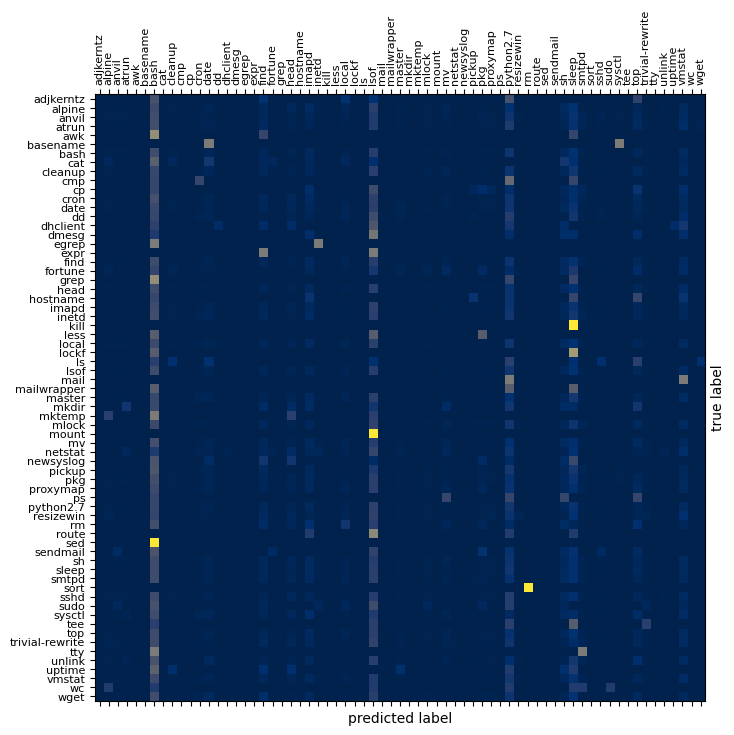

In [34]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality), normalize='true')

# transform to percentage
# conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
conf_matrix = np.nan_to_num(conf_matrix)

fig, ax = plt.subplots(figsize=(20*cm, 20*cm))

ax.matshow(conf_matrix, cmap='cividis', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90, fontsize=8)
ax.set_yticklabels(distinct_labels, fontsize=8)

# set axis labels "predicted" and "actual"
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
# y axis label right side
ax.yaxis.set_label_position('right')

checkpoint_path = 'saves/baseline'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# set figsize
plt.savefig(f'{checkpoint_path}/{experiment_type}_confusion_matrix.svg')
plt.show()